In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import accuracy_score, confusion_matrix

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
 % cd 'drive/My Drive/Project 2 - DS'

# Making future variables

Using this data for predicting `banking_crisis` till year 2024

In [31]:
data = pd.read_csv('african_crises.csv')
data['banking_crisis'] = data.banking_crisis.apply(lambda x: 1 if x == 'crisis' else 0)

data.drop(['case', 'cc3', 'gdp_weighted_default'], axis=1, inplace=True)
data.head()

,country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,Algeria,1870,1,0.052264,0,0,3.441456,0,0,0,1
1,Algeria,1871,0,0.052798,0,0,14.149140,0,0,0,0
2,Algeria,1872,0,0.052274,0,0,-3.718593,0,0,0,0
3,Algeria,1873,0,0.051680,0,0,11.203897,0,0,0,0
4,Algeria,1874,0,0.051308,0,0,-3.848561,0,0,0,0


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [0]:
categ_cols = ['systemic_crisis', 'domestic_debt_in_default', 'sovereign_external_debt_default',
                'independence', 'currency_crises', 'inflation_crises']
  
cont_cols = ['exch_usd', 'inflation_annual_cpi']            

def Make_models(N=3, cols_type='categ'):
  '''
  Taking N past years of the selected feature and only last year data for rest of the features
  '''

  MODELS = []

  Feature_var = categ_cols if cols_type== 'categ' else cont_cols

  for feature in Feature_var:

  # for feature in categ_cols:
    if cols_type== 'categ':
      categories = ['systemic_crisis', 'domestic_debt_in_default', 'sovereign_external_debt_default',
                  'independence', 'currency_crises', 'inflation_crises']
    else:
      categories = ['exch_usd', 'inflation_annual_cpi']            

    categories.remove(feature)

    Xl = []
    yl = []

    for country in data.country.unique():
      data_sub = data[data.country == country]
      data_sub= data_sub.reset_index()

      L = len(data_sub)

      Model_x = []
      Model_y = []

      for j in range(N, L):
        # NOTE: Flattening the variables appends the latest values in the end
        # => Data for 1996-2005:  [f1_96, ...fn_96, f1_97, ..fn_97, .... fn_05]
        variables = data_sub.loc[j-N:j-1, Feature_var].to_numpy().flatten()

        Model_x.append(variables) 
        Model_y.append(data_sub.loc[j, feature]) 

      Xl.append(np.array(Model_x))
      yl.append(np.array(Model_y))

      Y = np.array(yl)
      Y = np.hstack( np.array(Y) )
      X = Xl[0]

      for X_data in Xl[1:]:
        X = np.concatenate((X, X_data))

    X_train, X_test, y_train, y_test = train_test_split(X, Y)

    if cols_type== 'categ':

      model = DecisionTreeClassifier(random_state=0)
      model.fit(X_train, y_train)
      print(feature, np.mean( cross_val_score(model, X_test, y_test, cv=3, scoring='balanced_accuracy') ) )
        

    else:       # Continuous
      model = RandomForestRegressor(random_state=1)
      model.fit(X_train, y_train)
      print(feature, np.mean( cross_val_score(model, X_test, y_test, cv=3, scoring='neg_mean_squared_error') ) )

    MODELS.append(model)

  return MODELS

In [38]:
# Prediction accuracy for categorical variables
MODELS = Make_models(5)

systemic_crisis 0.8100459482038428
domestic_debt_in_default 0.8409194796061885
sovereign_external_debt_default 0.8803596801039256
independence 0.9952380952380953
currency_crises 0.7224296960212454
inflation_crises 0.8004006964623404


There is a lot of variation in currency and inflation. A single model can't be build for all countries. Results show very high errors. So using a moving average technique.

In [0]:
N = 5       # Years in Make_models
new_df = pd.DataFrame()

for country in data.country.unique():
  data_sub = data[data.country == country]

  new_df = new_df.append(data_sub, ignore_index=True)

  last_ind = new_df.index[-1]

  last_yr = new_df['year'].loc[last_ind]

  # Some countries have data till 2013 and others upto 2014. 
  # Following adjustment in order to predict everything till 2024
  N_years = 10 if last_yr == 2014 else 11

  for year in range(1, N_years+1): # 10 years of prediction

    X_categ_history = new_df.loc[last_ind-N+1 : last_ind+1, categ_cols].to_numpy().flatten()

    pred_year = []

    for (categ, clf) in zip(categ_cols, MODELS):
      X_pred = np.array([X_categ_history])

      new_df.loc[last_ind+1, 'country'] = country
      new_df.loc[last_ind+1, 'year'] = last_yr + year

      y_pred = clf.predict(X_pred)
      
      new_df.loc[last_ind+1, categ] = y_pred
      
    for cont in cont_cols:    # Past 3 years only

      X_cont_history = new_df.loc[last_ind-3+1 : last_ind, cont].to_numpy()
      y_pred = np.mean(X_cont_history)
      new_df.loc[last_ind+1, cont] = y_pred

    last_ind += 1

In [40]:
new_df

,country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,Algeria,1870.0,1.0,0.052264,0.0,0.0,3.441456,0.0,0.0,0.0,1.0
1,Algeria,1871.0,0.0,0.052798,0.0,0.0,14.149140,0.0,0.0,0.0,0.0
2,Algeria,1872.0,0.0,0.052274,0.0,0.0,-3.718593,0.0,0.0,0.0,0.0
3,Algeria,1873.0,0.0,0.051680,0.0,0.0,11.203897,0.0,0.0,0.0,0.0
4,Algeria,1874.0,0.0,0.051308,0.0,0.0,-3.848561,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1186,Zimbabwe,2020.0,0.0,361.900000,1.0,1.0,2.902837,1.0,0.0,0.0,NaN
1187,Zimbabwe,2021.0,0.0,361.900000,1.0,1.0,2.869363,1.0,0.0,0.0,NaN
1188,Zimbabwe,2022.0,0.0,361.900000,1.0,1.0,2.871479,1.0,0.0,0.0,NaN
1189,Zimbabwe,2023.0,0.0,361.900000,1.0,1.0,2.881226,1.0,0.0,0.0,NaN


In [0]:
import math

countries = new_df.country.unique()

for i, country in enumerate(countries):
  df_country = new_df[new_df.country == country]
  df_1 = df_country.iloc[:,2:].shift(1)  # Trimming the data to remove the first 2 columns
  df_2 = df_country.iloc[:,2:].shift(2)
  df_3 = df_country.iloc[:,2:].shift(3)

  df_23 = df_2.join(df_3, how='outer', lsuffix='_2', rsuffix='_3')
  df_01 = df_country.join(df_1, how='outer', lsuffix='', rsuffix='_1')
  df_all = df_01.join(df_23, how='outer')
  df_all = df_all.iloc[3:]  # To remove the NaN rows



  if i == 0:
    df_train = df_all[df_all.banking_crisis.isna() == False]  #.iloc[:N_train]
    df_test = df_all[df_all.banking_crisis.isna() == True]
    # print(df_all.banking_crisis_3.isna())
    check = df_all#.banking_crisis_3.isna()

  else:

    df_train = df_train.append(df_all[df_all.banking_crisis.isna() == False], ignore_index=True)
    df_test = df_test.append(df_all[df_all.banking_crisis.isna() == True], ignore_index=True)
    
df_train = pd.get_dummies(df_train, columns=['country'])
df_test = pd.get_dummies(df_test, columns=['country'])

In [0]:
# Saving the features with lag of 3 days in a separate csv
# Training on everything since hyperparameters already optimized by splitting the train data
# Test data only contains lag features for years to be predicted

df_train.to_csv('Time_lag/Final_train.csv', index=False)
df_test.to_csv('Time_lag/Final_test.csv', index=False)

# Predictions for the next decade


In [0]:
train = pd.read_csv('Time_lag/Final_train.csv')
pred =  pd.read_csv('Time_lag/Final_test.csv')

In [0]:
X = train.drop(columns=['year', 'banking_crisis']).to_numpy()
y = train.banking_crisis.to_numpy()

In [0]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, random_state=42)  

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

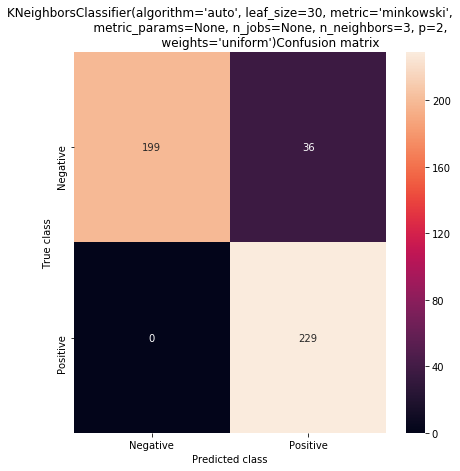

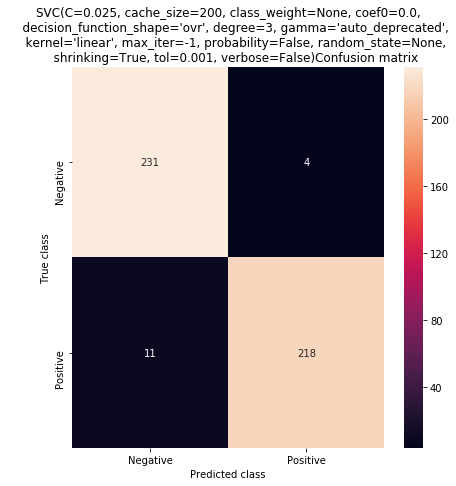

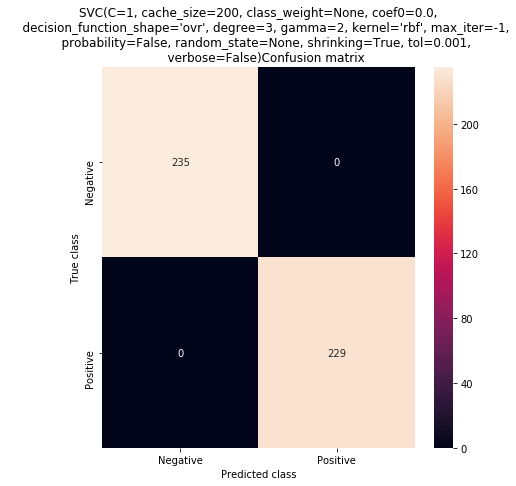

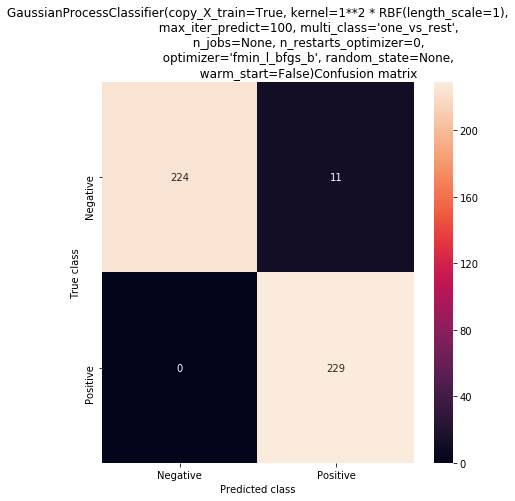

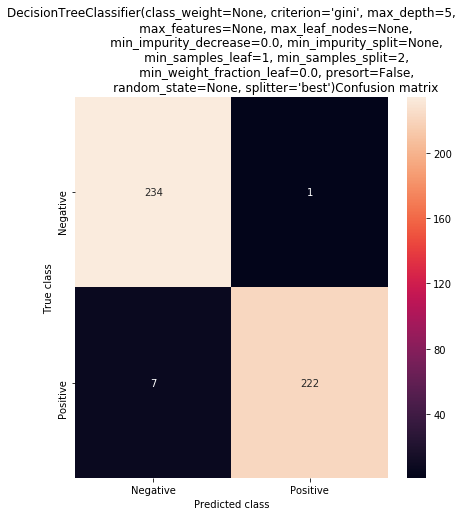

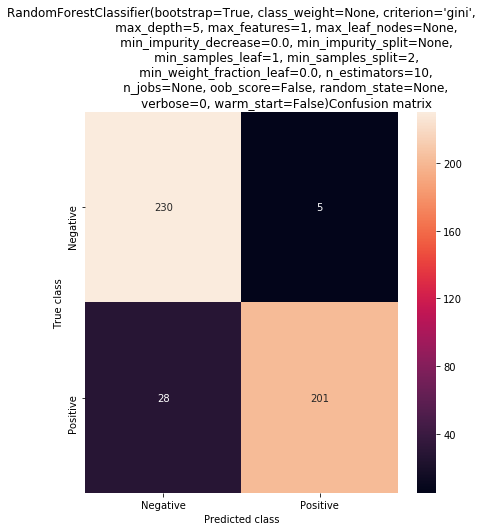

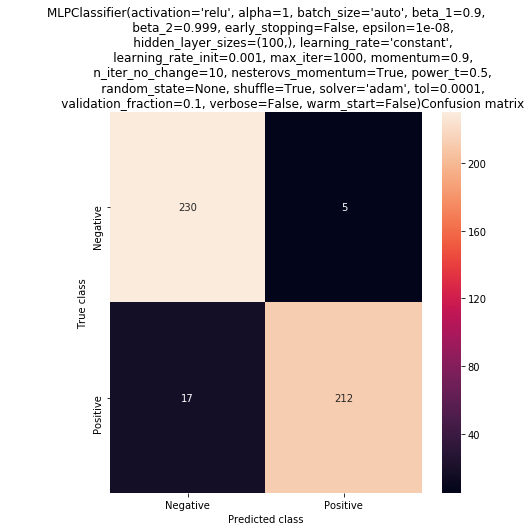

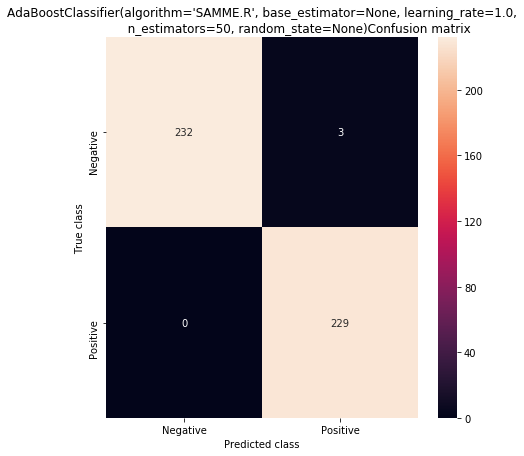

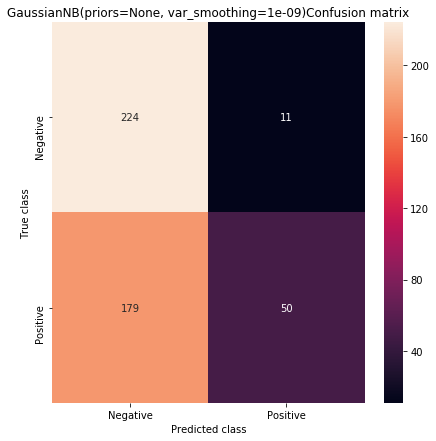

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


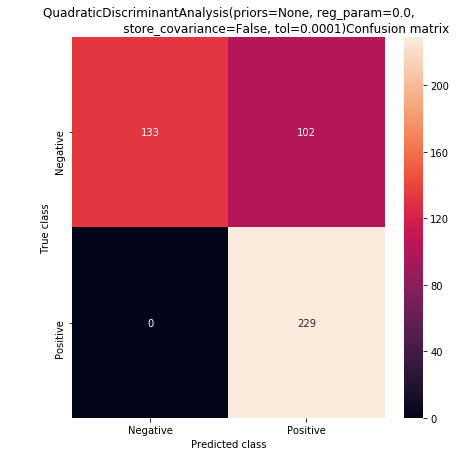

In [0]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7, 7))
    Label_name=['Negative','Positive']
    sns.heatmap(conf_matrix, xticklabels=Label_name, yticklabels=Label_name, annot=True, fmt="d")
    plt.title(str(clf) + "Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
def grid_search(clf, param_grid):
    # instantiate the grid
    grid = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

    # fit the grid with data
    grid.fit(X_train, y_train)
    
    # examine the best model
    print(grid.best_score_)
    print(grid.best_params_)  
    print(grid.best_estimator_)

    return grid.best_estimator_

In [0]:
clf_best = []

In [0]:
dtc = DecisionTreeClassifier()

# Define the parameter values that should be searched
sample_split_range = list(range(2, 50))
criterion = ['gini', 'entropy']
max_depth = list(range(2,10))

# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(min_samples_split=sample_split_range,
                  criterion=criterion,
                  max_depth=max_depth)

clf_best.append(grid_search(dtc, param_grid))

0.9877697841726619
{'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 2}
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


In [0]:
abc = AdaBoostClassifier()

# Define the parameter values that should be searched
n_estimators = list(range(10,250,10))
learning_rate = [0.01,0.05,0.1,0.2,0.5,1]

# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_estimators=n_estimators,
                  learning_rate=learning_rate)

clf_best.append(grid_search(abc, param_grid))

0.9913669064748202
{'learning_rate': 1, 'n_estimators': 230}
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=230, random_state=None)


In [0]:
rfc = RandomForestClassifier()

param_grid = {'bootstrap': [True, False],
              'max_depth': [10, 20, 30, None],
              'max_features': ['auto', 'sqrt', 'log2'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [50,100,200]}

clf_best.append(grid_search(rfc, param_grid))

0.9942446043165467
{'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=20, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [0]:
svc = SVC(gamma=2, C=1)

# Cs = [0.001, 0.01, 0.1, 1, 10]
# gammas = [0.001, 0.01, 0.1, 1]
# kernel = ['linear', 'rbf']

# param_grid = dict(C=Cs,
#                   gamma=gammas,
#                   kernel=kernel)

# clf_best.append(grid_search(svc, param_grid))
clf_best.append(svc)

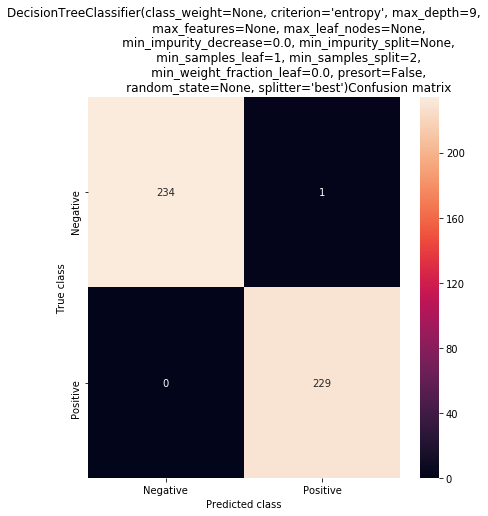

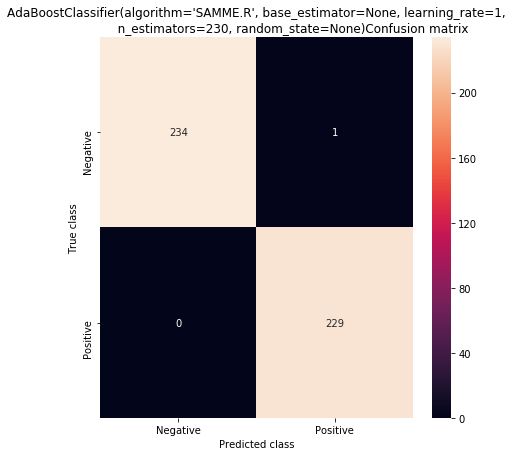

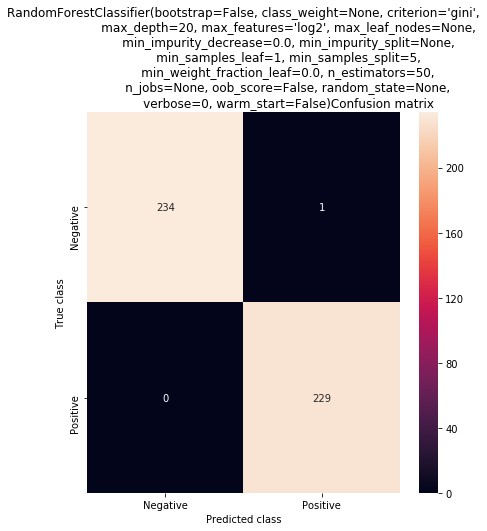

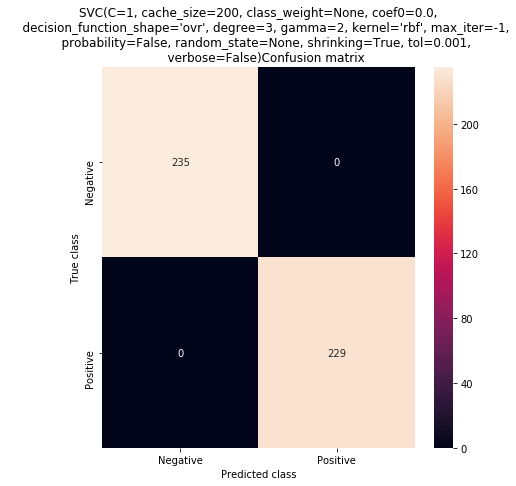

In [0]:
for clf in clf_best:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7, 7))
    Label_name=['Negative','Positive']
    sns.heatmap(conf_matrix, xticklabels=Label_name, yticklabels=Label_name, annot=True, fmt="d")
    plt.title(str(clf) + "Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

In [0]:
import joblib

In [0]:
joblib.dump(clf_best[0],'decision_tree_classifier.pickle')
joblib.dump(clf_best[1],'adaboost_tree_classifier.pickle')
joblib.dump(clf_best[2],'random_forest_classifier.pickle')
joblib.dump(clf_best[3],'svm_classifier.pickle')

['svm_classifier.pickle']

## Predictions

In [0]:
X_pred = pred.drop(columns=['year', 'banking_crisis']).to_numpy()

In [0]:
abc = joblib.load('adaboost_tree_classifier.pickle')
dtc = joblib.load('decision_tree_classifier.pickle')
rfc = joblib.load('random_forest_classifier.pickle')
svm = joblib.load('svm_classifier.pickle')

In [0]:
pred.head()

,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis,systemic_crisis_1,exch_usd_1,domestic_debt_in_default_1,sovereign_external_debt_default_1,inflation_annual_cpi_1,independence_1,currency_crises_1,inflation_crises_1,banking_crisis_1,systemic_crisis_2,exch_usd_2,domestic_debt_in_default_2,sovereign_external_debt_default_2,inflation_annual_cpi_2,independence_2,currency_crises_2,inflation_crises_2,banking_crisis_2,systemic_crisis_3,exch_usd_3,domestic_debt_in_default_3,sovereign_external_debt_default_3,inflation_annual_cpi_3,independence_3,currency_crises_3,inflation_crises_3,banking_crisis_3,country_Algeria,country_Angola,country_Central African Republic,country_Egypt,country_Ivory Coast,country_Kenya,country_Mauritius,country_Morocco,country_Nigeria,country_South Africa,country_Tunisia,country_Zambia,country_Zimbabwe
0,2015.0,0.0,81.407300,0.0,0.0,5.029333,1.0,0.0,0.0,NaN,0.0,87.970698,0.0,0.0,2.917000,1.0,0.0,0.0,0.0,0.0,78.148701,0.0,0.0,3.255000,1.0,0.0,0.0,0.0,0.0,78.102500,0.0,0.0,8.916000,1.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2016.0,0.0,82.508900,0.0,0.0,3.733778,1.0,0.0,0.0,NaN,0.0,81.407300,0.0,0.0,5.029333,1.0,0.0,0.0,NaN,0.0,87.970698,0.0,0.0,2.917000,1.0,0.0,0.0,0.0,0.0,78.148701,0.0,0.0,3.255000,1.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2017.0,0.0,83.962299,0.0,0.0,3.893370,1.0,0.0,0.0,NaN,0.0,82.508900,0.0,0.0,3.733778,1.0,0.0,0.0,NaN,0.0,81.407300,0.0,0.0,5.029333,1.0,0.0,0.0,NaN,0.0,87.970698,0.0,0.0,2.917000,1.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,2018.0,0.0,82.626166,0.0,0.0,4.218827,1.0,0.0,0.0,NaN,0.0,83.962299,0.0,0.0,3.893370,1.0,0.0,0.0,NaN,0.0,82.508900,0.0,0.0,3.733778,1.0,0.0,0.0,NaN,0.0,81.407300,0.0,0.0,5.029333,1.0,0.0,0.0,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0
4,2019.0,0.0,83.032455,0.0,0.0,3.948658,1.0,0.0,0.0,NaN,0.0,82.626166,0.0,0.0,4.218827,1.0,0.0,0.0,NaN,0.0,83.962299,0.0,0.0,3.893370,1.0,0.0,0.0,NaN,0.0,82.508900,0.0,0.0,3.733778,1.0,0.0,0.0,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
def Predictor(model, name):
  
  pred =  pd.read_csv('Time_lag/Final_test.csv')
 
  for j in pred.index:

    df = pred.iloc[j]

    X_pred = df.drop(['year', 'banking_crisis']).to_numpy()
    y_out = model.predict(X_pred.reshape(1,-1))

    if df.year <= 2024:
      pred.loc[j, 'banking_crisis'] = y_out

    if df.year <= 2023:
      pred.loc[j+1, 'banking_crisis_1'] = y_out

    if df.year <= 2022:
      pred.loc[j+2, 'banking_crisis_2'] = y_out

    if df.year <= 2021:
      pred.loc[j+3, 'banking_crisis_3'] = y_out

  pred.to_csv('Predictions_'+name+'.csv', index=False)
    

In [0]:
Predictor(abc, 'abc')
Predictor(dtc, 'dtc')
Predictor(rfc, 'rfc')
Predictor(svm, 'svm')